In [1]:
from __future__ import absolute_import, division, print_function

from hippylib import nb
import dolfin as dl
import math
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
logging.getLogger('UFC').setLevel(logging.ERROR)
dl.set_log_active(False)

sys.path.insert(0,'/home/fenics/Installations/MUQ_INSTALL/lib')
from IPython.display import Image
import pandas as pd


# MUQ Includes
import pymuqModeling as mm # Needed for Gaussian distribution
import pymuqApproximation as ma # Needed for Gaussian processes
import pymuqSamplingAlgorithms as ms # Needed for MCMC

nx = ny = 10
mesh = dl.RectangleMesh(dl.Point(0, 0),dl.Point(1,1),nx,ny,"right")
V = dl.FunctionSpace(mesh, 'P', 1)

class PAT_forward(mm.PyModPiece):
    
    def __init__(self, time_final, numSteps, c, V):
        """ 
        INPUTS:
        
        """
        mm.PyModPiece.__init__(self, [V.dim()],
                                [V.dim()])
                  
        self.T_f = time_final
        self.numSteps = numSteps
        self.dt = self.T_f / self.numSteps
        self.c = c
        self.V = V
        
        self.p_trial = dl.TrialFunction(self.V)
        self.v = dl.TestFunction(self.V)
            
    def EvaluateImpl(self, inputs):
        """
        
        """
        m = dl.Function(self.V)
        m.vector().set_local(inputs[0])
        
        p_n = dl.interpolate(m, self.V)
        p_nm1 = dl.interpolate(m, self.V)
        p_trial = self.p_trial
        v = self.v
        
        F = (self.c**2)*(self.dt**2)*dl.inner(dl.grad(p_trial), dl.grad(v))*dl.dx - 2.*p_n*v*dl.dx + p_trial*v*dl.dx + p_nm1*v*dl.dx 
        a, L = dl.lhs(F), dl.rhs(F)
        
        # Time-stepping
        p = dl.Function(self.V)
        t = 0
        for n in range(self.numSteps):
            # Update current timtime
            t += self.dt

            # Compute solution
            dl.solve(a == L, p)

            # Update previous solution
            p_nm1.assign(p_n)
            p_n.assign(p)

        out = p.vector().array()[:]
        
        self.outputs = [out]

time_final = 0.05
numSteps = 1000
c = 1.5
test = PAT_forward(time_final, numSteps, c, V)
m = dl.interpolate(dl.Expression('std::log( 8. - 4.*(pow(x[0] - .5,2) + pow(x[1] - .5,2) < pow(0.2,2) ) )', degree=5), V)
obsData = test.Evaluate([m.vector().array()[:]])   

m = dl.Function(V)
m.vector().set_local(obsData[0])
nb.plot(m)
plt.show()

/usr/lib/python3/dist-packages/dolfin/cpp/la.py:1331: DeprecationWarning: GenericVector.array() is being deprecated, use GenericVector.get_local()
  "use GenericVector.get_local()", DeprecationWarning)
/usr/lib/python3/dist-packages/dolfin/cpp/la.py:1331: DeprecationWarning: GenericVector.array() is being deprecated, use GenericVector.get_local()
  "use GenericVector.get_local()", DeprecationWarning)


In [2]:
fwdSolver = PAT_forward(time_final, numSteps, c, V)

# Prior
m = dl.interpolate(dl.Expression('std::log( 8. - 4.*(pow(x[0] - .5,2) + pow(x[1] - .5,2) < pow(0.2,2) ) )', degree=5), V)
#logPriorMu = 2*np.ones(V.dim())
logPriorMu = m.vector().array()[:]
logPriorCov = 0.02*np.eye(V.dim())
logPrior = mm.Gaussian(logPriorMu, logPriorCov).AsDensity()

# Data      
time_final = 0.05
numSteps = 100
c = 1.5
test = PAT_forward(time_final, numSteps, c, V)
m = dl.interpolate(dl.Expression('std::log( 8. - 4.*(pow(x[0] - .5,2) + pow(x[1] - .5,2) < pow(0.2,2) ) )', degree=5), V)
obsData = test.Evaluate([m.vector().array()[:]])[0]   


/usr/lib/python3/dist-packages/dolfin/cpp/la.py:1331: DeprecationWarning: GenericVector.array() is being deprecated, use GenericVector.get_local()
  "use GenericVector.get_local()", DeprecationWarning)
/usr/lib/python3/dist-packages/dolfin/cpp/la.py:1331: DeprecationWarning: GenericVector.array() is being deprecated, use GenericVector.get_local()
  "use GenericVector.get_local()", DeprecationWarning)
/usr/lib/python3/dist-packages/dolfin/cpp/la.py:1331: DeprecationWarning: GenericVector.array() is being deprecated, use GenericVector.get_local()
  "use GenericVector.get_local()", DeprecationWarning)


# Likelihood

In [3]:
noiseVar = 1e-4
noiseCov = noiseVar*np.eye(obsData.shape[0])
likelihood = mm.Gaussian(obsData, noiseCov).AsDensity()

# Posterior

In [4]:
posteriorPiece = mm.DensityProduct(2)
p_0 = mm.IdentityOperator(V.dim())

In [5]:
graph = mm.WorkGraph()

# Forward model nodes and edges
graph.AddNode(p_0, "p_0")
#graph.AddNode(obsOperator, "B")
graph.AddNode(fwdSolver, "u")

graph.AddEdge("p_0", 0, "u", 0)
#graph.AddEdge("u", 0, "B", 0)

# Other nodes and edges
graph.AddNode(likelihood, "Likelihood")
graph.AddNode(logPrior, "Prior")
graph.AddNode(posteriorPiece,"Posterior")

#graph.AddEdge("B", 0, "Likelihood", 0)
graph.AddEdge("u", 0, "Likelihood", 0)
graph.AddEdge("p_0", 0, "Prior", 0)
graph.AddEdge("Prior",0,"Posterior",0)
graph.AddEdge("Likelihood",0, "Posterior",1)

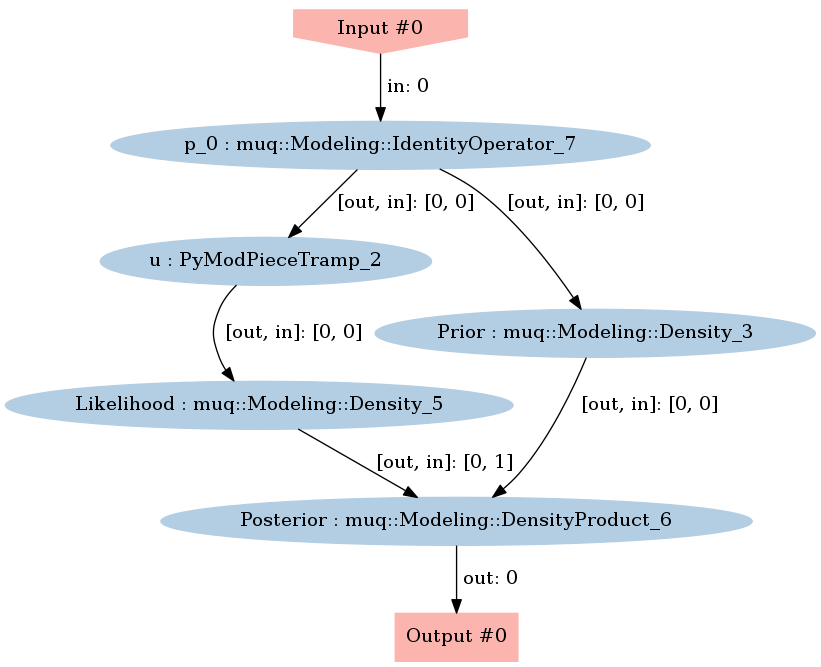

In [6]:
graph.Visualize("PosteriorGraph.png")
Image(filename='PosteriorGraph.png') 

In [7]:
problem = ms.SamplingProblem(graph.CreateModPiece("Posterior"))

In [8]:
proposalOptions = dict()
proposalOptions['Method'] = 'AMProposal'
proposalOptions['ProposalVariance'] = 1e-2
proposalOptions['AdaptSteps'] = 100
proposalOptions['AdaptStart'] = 1000
proposalOptions['AdaptScale'] = 0.1

kernelOptions = dict()
kernelOptions['Method'] = 'MHKernel'
kernelOptions['Proposal'] = 'ProposalBlock'
kernelOptions['ProposalBlock'] = proposalOptions

options = dict()
options['NumSamples'] = 10
options['ThinIncrement'] = 1
options['BurnIn'] = 1
options['KernelList'] = 'Kernel1'
options['PrintLevel'] = 3
options['Kernel1'] = kernelOptions

mcmc = ms.SingleChainMCMC(options,problem)

In [9]:
startPt = np.log(8.0) * np.ones((V.dim()))
samps = mcmc.Run(startPt)

Starting single chain MCMC sampler...
  10% Complete


/usr/lib/python3/dist-packages/dolfin/cpp/la.py:1331: DeprecationWarning: GenericVector.array() is being deprecated, use GenericVector.get_local()
  "use GenericVector.get_local()", DeprecationWarning)
/usr/lib/python3/dist-packages/dolfin/cpp/la.py:1331: DeprecationWarning: GenericVector.array() is being deprecated, use GenericVector.get_local()
  "use GenericVector.get_local()", DeprecationWarning)


    Block 0:
      Acceptance Rate = 0%
  20% Complete
    Block 0:
      Acceptance Rate = 0%


/usr/lib/python3/dist-packages/dolfin/cpp/la.py:1331: DeprecationWarning: GenericVector.array() is being deprecated, use GenericVector.get_local()
  "use GenericVector.get_local()", DeprecationWarning)


  30% Complete
    Block 0:
      Acceptance Rate = 0%
  40% Complete
    Block 0:
      Acceptance Rate = 0%


/usr/lib/python3/dist-packages/dolfin/cpp/la.py:1331: DeprecationWarning: GenericVector.array() is being deprecated, use GenericVector.get_local()
  "use GenericVector.get_local()", DeprecationWarning)
/usr/lib/python3/dist-packages/dolfin/cpp/la.py:1331: DeprecationWarning: GenericVector.array() is being deprecated, use GenericVector.get_local()
  "use GenericVector.get_local()", DeprecationWarning)


  50% Complete
    Block 0:
      Acceptance Rate = 0%
  60% Complete
    Block 0:
      Acceptance Rate = 0%


/usr/lib/python3/dist-packages/dolfin/cpp/la.py:1331: DeprecationWarning: GenericVector.array() is being deprecated, use GenericVector.get_local()
  "use GenericVector.get_local()", DeprecationWarning)
/usr/lib/python3/dist-packages/dolfin/cpp/la.py:1331: DeprecationWarning: GenericVector.array() is being deprecated, use GenericVector.get_local()
  "use GenericVector.get_local()", DeprecationWarning)


  70% Complete
    Block 0:
      Acceptance Rate = 0%
  80% Complete
    Block 0:
      Acceptance Rate = 0%


/usr/lib/python3/dist-packages/dolfin/cpp/la.py:1331: DeprecationWarning: GenericVector.array() is being deprecated, use GenericVector.get_local()
  "use GenericVector.get_local()", DeprecationWarning)
/usr/lib/python3/dist-packages/dolfin/cpp/la.py:1331: DeprecationWarning: GenericVector.array() is being deprecated, use GenericVector.get_local()
  "use GenericVector.get_local()", DeprecationWarning)


  100% Complete
    Block 0:
      Acceptance Rate = 0%
Completed in 33.8498 seconds.


/usr/lib/python3/dist-packages/dolfin/cpp/la.py:1331: DeprecationWarning: GenericVector.array() is being deprecated, use GenericVector.get_local()
  "use GenericVector.get_local()", DeprecationWarning)


In [10]:
ess = samps.ESS()
print('Effective Sample Size = \n', ess)

sampMean = samps.Mean()
print('\nSample mean = \n', sampMean)

sampCov = samps.Covariance()
print('\nSample Covariance = \n', sampCov)

mcErr = np.sqrt( samps.Variance() / ess)
print('\nEstimated MC error in mean = \n', mcErr)

Effective Sample Size = 
 [-9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9.
 -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9.
 -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9.
 -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9.
 -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9.
 -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9.
 -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9. -9.]

Sample mean = 
 [ 2.07944154  2.07944154  2.07944154  2.07944154  2.07944154  2.07944154
  2.07944154  2.07944154  2.07944154  2.07944154  2.07944154  2.07944154
  2.07944154  2.07944154  2.07944154  2.07944154  2.07944154  2.07944154
  2.07944154  2.07944154  2.07944154  2.07944154  2.07944154  2.07944154
  2.07944154  2.07944154  2.07944154  2.07944154  2.07944154  2.07944154
  2.07944154  2.07944154  2.07944154  2.07944154  2.07944154  2.07944154
  2.07944154  2.07944154  2